## MFW Chapter 3: Methods and Data

This chapter will be divided into the following subsections:

1. Introduction to the database
2. Details on the main data subset used 
3. Monthly aggregation of claim counts and severities
4. Overview of claim detrending process

In [1]:
#loading the required libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#changing the plot configuration:
plt.rcParams['figure.figsize'] = (5, 5)
plt.style.use('seaborn')

### Subsection 1: Introduction to the database 

**1. First we will load the big data set and look at the variables included:**

In [2]:
#loading the database:
data = pd.read_csv("big_data.csv")
data.head()

C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Claim Number,Date,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2.00503E+12,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,"Baby - Strollers, car seats, playpen, etc.",$84.79,Approved,$84.79,Approve in Full


In [3]:
#viewing the dimensions of this dataset:
data.shape

(204262, 13)

**2. Plotting all of the claims by disposition:**

C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


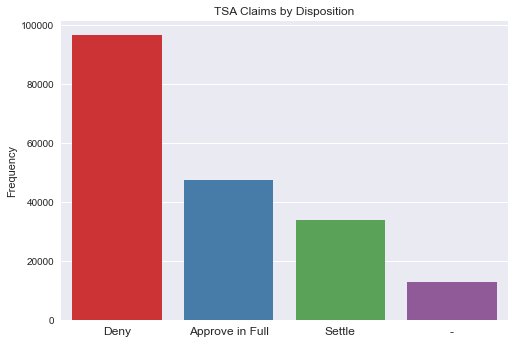

In [4]:
#plotting the claims disposition:
dispos = data['Disposition'].value_counts()
sns.barplot(dispos.index, dispos.values, palette="Set1")
plt.ylabel('Frequency')
plt.title("TSA Claims by Disposition")
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.savefig('claims_by_disposition.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
#for greater detail:
dispos

Deny               96619
Approve in Full    47374
Settle             33733
-                  12752
Name: Disposition, dtype: int64

### Subsection 2: Details on the main data subset used

**1. Making the main data subset**

In [4]:
dfs = data[(data['Disposition'] == 'Approve in Full') | (data['Disposition'] == 'Settle')]
dfs.shape

(81107, 13)

**2. Processing and plotting the close amounts:**

In [5]:
def split_amount(x):
    try:
        if x is not None:
            a = x.split('$')[1]
            if ';' in a:
                b,c = a.split(';')
                return eval(b + c)
            return eval(a)
    except:
        return 0

dfs['Close Amount'] = dfs['Close Amount'].apply(split_amount)
print("Maximum closed amount  : ", dfs['Close Amount'].max())
print("Average closed amount  : ", dfs['Close Amount'].mean())

Maximum closed amount  :  125000.0
Average closed amount  :  198.64198614176337


C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


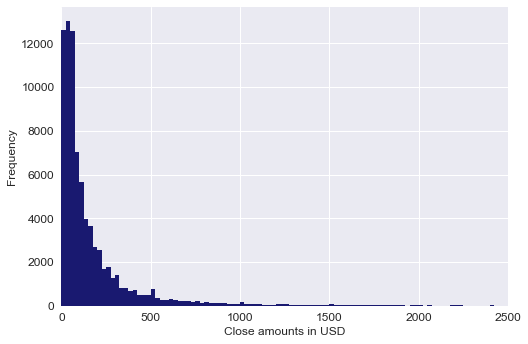

In [76]:
#making a histogram of the processed closed amounts:
dfs['Close Amount'].hist(bins=5000, grid=True, xlabelsize=12, ylabelsize=12, color="midnightblue")
plt.xlabel("Close amounts in USD", fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.xlim([0,2500])
plt.savefig('hist_close_amounts.png', dpi=300, bbox_inches='tight')

**3. Descriptive statistics of the close amounts**

In [96]:
dfs['Close Amount'].describe()

count     81107.000000
mean        198.641986
std         754.079093
min           0.000000
25%          37.800000
50%          80.000000
75%         197.000000
max      125000.000000
Name: Close Amount, dtype: float64

In [97]:
import statistics
statistics.mode(dfs['Close Amount'])

50.0

**4. Plotting the claims by type:**

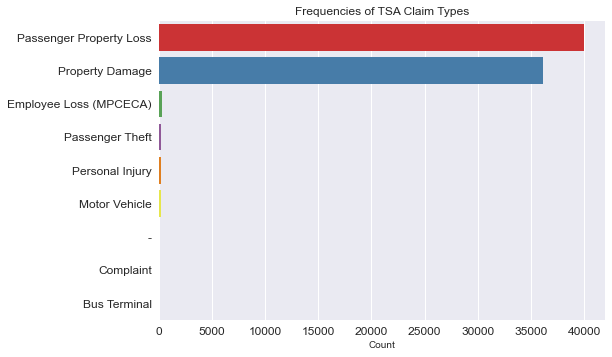

In [29]:
#making a subet of the unique claims by type:
unique_claim_type = dfs['Claim Type'].value_counts()
claim_index = unique_claim_type.index
claim_values = unique_claim_type.values

#plotting this series:
sns.barplot(y=claim_index, x=claim_values, orient='horizontal', palette="Set1")
plt.title("Frequencies of TSA Claim Types", fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('claims_type.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
unique_claim_type 

Passenger Property Loss    39968
Property Damage            36112
Employee Loss (MPCECA)       275
Passenger Theft              254
Personal Injury              247
Motor Vehicle                201
-                             39
Complaint                      5
Bus Terminal                   1
Name: Claim Type, dtype: int64

**5. Plotting the claims by site:**

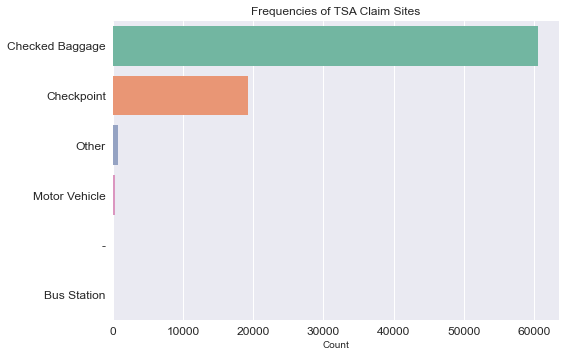

In [38]:
#making a subet of the unique claims by site:
unique_claim_site = dfs['Claim Site'].value_counts()
claim_index = unique_claim_site.index
claim_values = unique_claim_site.values

#plotting this series:
sns.barplot(y=claim_index, x=claim_values, orient='horizontal', palette="Set2")
plt.title("Frequencies of TSA Claim Sites", fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('claims_site.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
unique_claim_site

Checked Baggage    60574
Checkpoint         19308
Other                721
Motor Vehicle        254
-                      8
Bus Station            1
Name: Claim Site, dtype: int64

### Subsection 3: Monthly aggregation of claim counts and severities

**1. Transforming the received date into a datetime object**

In [6]:
dfs['Date'] = pd.to_datetime(dfs['Date'], format="%d-%b-%y")
dfs.set_index('Date', inplace=True)
dfs.head()

C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Claim Number,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
Date,,,,,,,,,,,,
2002-01-04,0909802M,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,350.00,Approve in Full
2002-02-02,0202417M,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,50.00,Settle
2002-02-04,0202445M,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,227.92,Settle
2002-02-07,0909816M,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,50.00,Approve in Full
2002-02-18,2.00503E+12,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,"Baby - Strollers, car seats, playpen, etc.",$84.79,Approved,84.79,Approve in Full


In [7]:
#saving this to a new .csv file with the dates we want:
dfs = dfs.loc['2003-01-01':'2015-12-31']
dfs.to_csv('clean_sample.csv')

2. Data aggregation of the series we want:

In [8]:
#PROPERTY DAMAGE:
ppd = dfs[(dfs['Claim Type'] == 'Property Damage')]
pdx = ppd['Close Amount'].resample('MS').count()
pds = ppd['Close Amount'].resample('MS').sum()

#PROPERTY LOSS:
ppl = dfs[(dfs['Claim Type'] == 'Passenger Property Loss')]
plx = ppl['Close Amount'].resample('MS').count()
pls = ppl['Close Amount'].resample('MS').sum()

#CHECKED BAGGAGE:
cb = dfs[(dfs['Claim Site'] == 'Checked Baggage')]
cbx = cb['Close Amount'].resample('MS').count()
cbs = cb['Close Amount'].resample('MS').sum()

#SECURITY CHECKPOINT:
cp = dfs[(dfs['Claim Site'] == 'Checkpoint')]
cpx = cp['Close Amount'].resample('MS').count()
cps = cp['Close Amount'].resample('MS').sum()

#PUTTING IT ALL TOGETHER:
dfinal = pd.concat([pdx, pds, plx, pls, cbx, cbs, cpx, cps], axis=1)
#renaming the columns:
dfinal.columns = ['pdx', 'pds', 'plx', 'pls', 'cbx', 'cbs', 'cpx', 'cps']
dfinal.describe()

,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,229.743590,43393.384423,255.448718,45801.327436,388.096154,59298.647628,120.897436,37450.703013
std,182.140955,23012.955179,208.589651,41028.606035,377.259229,59463.309234,56.016954,18528.229545
min,15.000000,4465.960000,14.000000,2033.880000,14.000000,1964.960000,14.000000,4121.360000
25%,127.750000,30391.940000,112.750000,18697.077500,157.250000,23802.515000,87.750000,26471.802500
50%,150.000000,37980.400000,152.000000,26495.180000,196.000000,30811.005000,105.500000,34139.190000
75%,259.500000,53313.577500,377.000000,62260.750000,507.500000,77035.832500,150.000000,46662.660000
max,873.000000,133835.070000,1007.000000,196328.290000,1670.000000,261424.430000,337.000000,137850.990000


In [9]:
#skewness:
dfinal.skew()

pdx    1.699948
pds    1.397938
plx    1.291725
pls    1.502830
cbx    1.551414
cbs    1.698192
cpx    0.986408
cps    1.349398
dtype: float64

In [10]:
#kurtosis:
dfinal.kurtosis()

pdx    2.165625
pds    2.798126
plx    0.824624
pls    1.637513
cbx    1.392266
cbs    2.040966
cpx    1.378317
cps    4.962354
dtype: float64

In [11]:
#exporting this to a .csv file
dfinal.to_csv('aggregated_series.csv')

**3. Plotting the series and obtaining some statistics:**

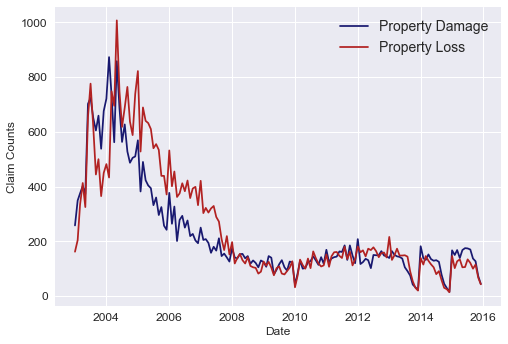

In [134]:
#counts by type:
plt.plot(dfinal['pdx'], label="Property Damage", color="midnightblue")
plt.plot(dfinal['plx'], label="Property Loss", color="firebrick")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Claim Counts", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('claims_raw_type.png', dpi=300, bbox_inches='tight')

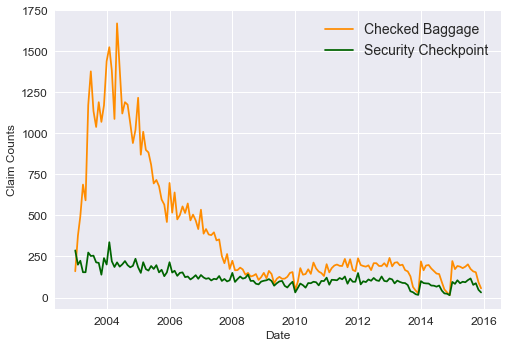

In [135]:
#counts by site:
plt.plot(dfinal['cbx'], label="Checked Baggage", color="darkorange")
plt.plot(dfinal['cpx'], label="Security Checkpoint", color="darkgreen")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Claim Counts", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('claims_raw_site.png', dpi=300, bbox_inches='tight')

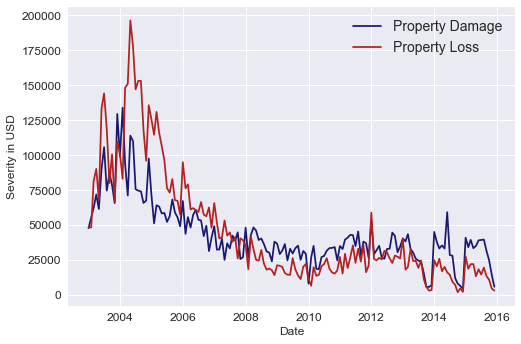

In [136]:
#severities by type:
plt.plot(dfinal['pds'], label="Property Damage", color="midnightblue")
plt.plot(dfinal['pls'], label="Property Loss", color="firebrick")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Severity in USD", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('claims_raw_type_s.png', dpi=300, bbox_inches='tight')

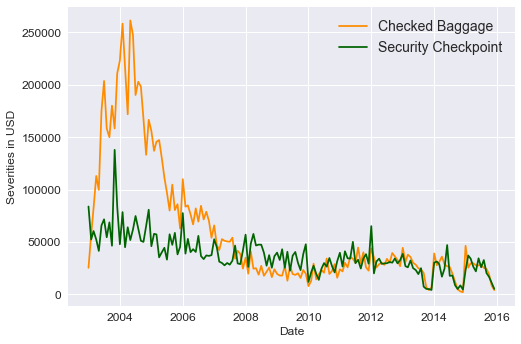

In [137]:
#severities by site:
plt.plot(dfinal['cbs'], label="Checked Baggage", color="darkorange")
plt.plot(dfinal['cps'], label="Security Checkpoint", color="darkgreen")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Severities in USD", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('claims_raw_site_s.png', dpi=300, bbox_inches='tight')

### Subsection 4: Overview of claim detrending process 

**1. Example for property damage counts**

This detrending method was taken from [here](https://towardsdatascience.com/removing-non-linear-trends-from-timeseries-data-b21f7567ed51).

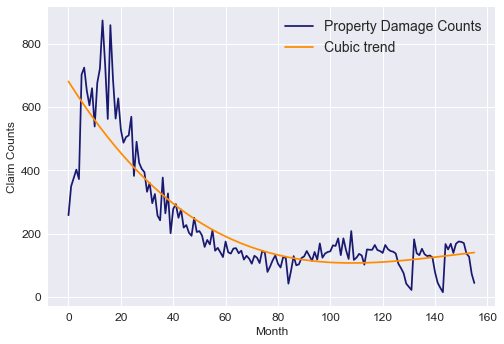

In [12]:
#############REMOVING THE DATE INDEX:
dfinal.reset_index(drop=True, inplace=True) 


ser = dfinal['pdx'].squeeze()
X = ser.index
X = np.reshape(X, (len(X), 1))
y = ser.values

pf = PolynomialFeatures(degree=3)
Xp = pf.fit_transform(X)
Xp

md2 = LinearRegression()
md2.fit(Xp, y)
trendp = md2.predict(Xp)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Claim Counts", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(y, color="midnightblue")
plt.plot(trendp, color="darkorange")
plt.legend(['Property Damage Counts', 'Cubic trend'], fontsize=14)
plt.savefig('detrending_process.png', dpi=300, bbox_inches='tight')

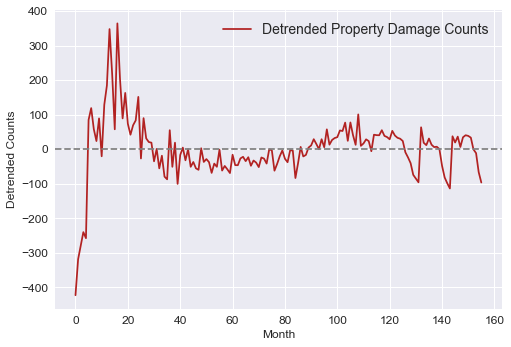

In [69]:
detrpoly = [y[i] - trendp[i] for i in range(0, len(y))]
plt.plot(X, detrpoly, color="firebrick")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Detrended Counts", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend(['Detrended Property Damage Counts'], fontsize=14)
plt.savefig('detrending_pdx.png', dpi=300, bbox_inches='tight')

**2. Defining and applying a function to detrend all the series**

In [13]:
def detrend(dcol, n):
    #takes a dataframe column WITHOUT index
    #n represents the polynomial order
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    ser = dcol.squeeze()
    X = ser.index
    X = np.reshape(X, (len(X), 1))
    y = ser.values
    pf = PolynomialFeatures(degree=n)
    Xp = pf.fit_transform(X)
    md2 = LinearRegression()
    md2.fit(Xp, y)
    trendp = md2.predict(Xp)
    detrpoly = [y[i] - trendp[i] for i in range(0, len(y))]
    return detrpoly


In [14]:
#making a new dataframe with the detrended values:
dftrend = dfinal.copy(deep=True) 
#applyting the detrend function to all the columns in this dataframe:
dftrend = dftrend.apply(lambda x : detrend(x,3))
dftrend.describe()

,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,3.753123e-14,1.774681e-11,-1.559550e-13,2.985008e-12,5.611466e-14,8.955025e-12,-3.279428e-15,2.763465e-12
std,8.981529e+01,1.394064e+04,1.167014e+02,2.230552e+04,1.980951e+02,3.275734e+04,2.876242e+01,1.251592e+04
min,-4.223615e+02,-4.634860e+04,-4.378416e+02,-7.900797e+04,-1.036661e+03,-1.651316e+05,-8.746980e+01,-2.681667e+04
25%,-3.907830e+01,-6.181272e+03,-7.741136e+01,-1.125709e+04,-8.708965e+01,-1.401144e+04,-1.350966e+01,-8.766360e+03
50%,1.889838e+00,8.814776e+02,-2.758647e+00,-2.496194e+03,-1.386099e+00,-2.069880e+03,2.265712e+00,1.125036e+02
75%,3.550041e+01,5.587979e+03,7.064126e+01,1.019178e+04,8.913627e+01,1.233685e+04,1.582114e+01,6.153436e+03
max,3.640041e+02,5.674145e+04,4.779544e+02,9.445369e+04,7.507874e+02,1.196577e+05,1.289910e+02,7.465435e+04


In [64]:
dftrend.skew()

pdx   -0.335510
pds    0.502013
plx    0.082246
pls    0.539739
cbx   -0.948758
cbs   -0.478972
cpx   -0.019620
cps    1.545010
dtype: float64

In [65]:
dftrend.kurtosis()

pdx    6.892239
pds    3.194746
plx    2.905790
pls    4.058583
cbx    7.944114
cbs    7.484436
cpx    2.880864
cps    7.412759
dtype: float64

**3. Plotting the detrended series:**

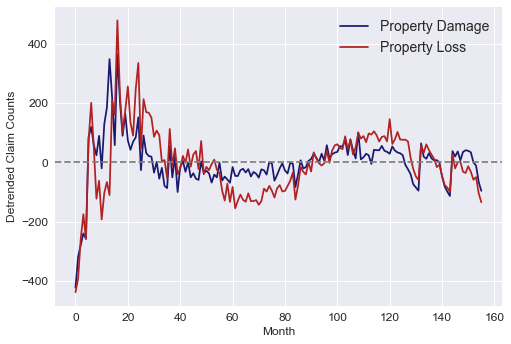

In [68]:
#detrended counts by type:
plt.plot(dftrend['pdx'], label="Property Damage", color="midnightblue")
plt.plot(dftrend['plx'], label="Property Loss", color="firebrick")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Detrended Claim Counts", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.savefig('claims_detrended_type.png', dpi=300, bbox_inches='tight')

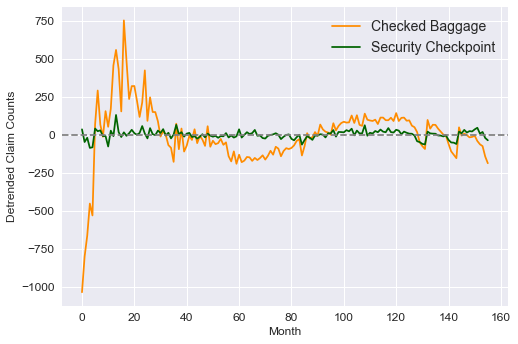

In [14]:
#detrended counts by site:
plt.plot(dftrend['cbx'], label="Checked Baggage", color="darkorange")
plt.plot(dftrend['cpx'], label="Security Checkpoint", color="darkgreen")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Detrended Claim Counts", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.savefig('claims_detrended_site.png', dpi=300, bbox_inches='tight')

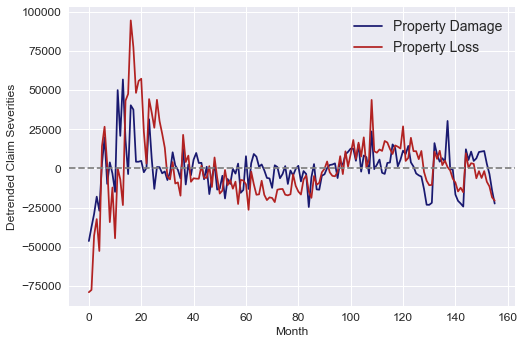

In [72]:
#detrended severities by type:
plt.plot(dftrend['pds'], label="Property Damage", color="midnightblue")
plt.plot(dftrend['pls'], label="Property Loss", color="firebrick")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Detrended Claim Severities", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.savefig('claims_detrended_type_s.png', dpi=300, bbox_inches='tight')

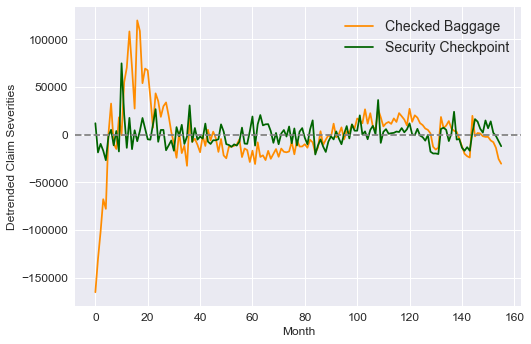

In [73]:
#detrended severities by site:
plt.plot(dftrend['cbs'], label="Checked Baggage", color="darkorange")
plt.plot(dftrend['cps'], label="Security Checkpoint", color="darkgreen")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Detrended Claim Severities", fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.savefig('claims_detrended_site_s.png', dpi=300, bbox_inches='tight')

In [16]:
#exporting this to a .csv file
dftrend.to_csv('aggregated_detrended_series.csv')